# Load Libraries

In [1]:
%load_ext autoreload
%autoreload 2
%reload_ext autoreload

import os
os.chdir("/home/dalai/GNN_E")
print(os.getcwd())

from scripts.models import *
import pandas as pd
from scripts.utils import *
from math import ceil
import gc


import torch
import torch.optim as optim

print(torch.cuda.is_available())
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)
print(torch.__version__)

/home/dalai/GNN_E


/home/dalai/.conda/envs/gat_gpu/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


True
cuda
1.13.1+cu116


# Load df all Movies

In [2]:
# Load all movies with labels csv
df_all_movies = pd.read_csv("data/processed/all_movies_labelled_13_single.csv")

num_classes = 13 # based on df_movie choosen
batch_size = 32
print(batch_size)

32


In [3]:
############à
#JUST FOR PROVA

df_all_movies = df_all_movies[df_all_movies.movie.isin([0,3])]

# Split in Train, Validation, Test

In [4]:
df_train, df_val, df_test = split_train_val_test_horizontally(
    df_all_movies, 
    percentage_train=0.8, 
    percentage_val=0.0, #0 to not have nay val set
    path_pickle_delay="data/raw/labels/run_onsets.pkl",
    path_movie_title_mapping="data/raw/labels/category_mapping_movies.csv", 
    tr_len=1.3
)


Movie: AfterTheRain
  Start Time (TR)+4: 80
  Total Length (TR): 382
  Train End (TR): 385
  Validation End (TR): 385
  Movie End (TR): 462

Movie: Chatter
  Start Time (TR)+4: 79
  Total Length (TR): 312
  Train End (TR): 328
  Validation End (TR): 328
  Movie End (TR): 391


In [6]:
# In case predict between rest ans movie
if False:
    df_rest = pd.read_csv("/home/dalai/GNN_E/data/raw/rest/Rest_compiled414_processed.csv")
    df_train, df_test = split_train_test_rest_classification(df_all_movies, df_rest)
    df_val = df_train[df_train.id == 99] #make sure to be empty

Classificable timepoints in train and test
596
label
-1    398
 0    325
 1    271
Name: count, dtype: int64
195
label
-1    799
 1    111
 0     84
Name: count, dtype: int64


# Create dataset (i.e. graph list)

In [7]:
dataset_train = DatasetEmo(df=df_train, node_feat="symmetricwindow")
dataset_val= DatasetEmo(df=df_val, node_feat="symmetricwindow")
dataset_test = DatasetEmo(df=df_test, node_feat="symmetricwindow")

# Extarct the list of graphs of each dataset
graphs_list_train = dataset_train.get_graphs_list()
graphs_list_val = dataset_val.get_graphs_list()
graphs_list_test = dataset_test.get_graphs_list()

print(f"Number Batces Train {len(graphs_list_train)/batch_size}")
print(f"Number Batces Val {len(graphs_list_val)/batch_size}")
print(f"Number Batces Test {len(graphs_list_test)/batch_size}")


Movies in this df: [ 0 77]
Creating the graph 0 1 0/271
Creating the graph 0 1 1/271
Creating the graph 0 1 2/271
Creating the graph 0 1 3/271
Creating the graph 0 1 4/271
Creating the graph 0 1 5/271
Creating the graph 0 1 6/271
Creating the graph 0 1 7/271
Creating the graph 0 1 8/271
Creating the graph 0 1 9/271
Creating the graph 0 1 10/271
Creating the graph 0 1 11/271
Creating the graph 0 1 12/271
Creating the graph 0 1 13/271
Creating the graph 0 1 14/271
Creating the graph 0 1 15/271
Creating the graph 0 1 16/271
Creating the graph 0 1 17/271
Creating the graph 0 1 18/271
Creating the graph 0 1 19/271
Creating the graph 0 1 20/271
Creating the graph 0 1 21/271
Creating the graph 0 1 22/271
Creating the graph 0 1 23/271
Creating the graph 0 1 24/271
Creating the graph 0 1 25/271
Creating the graph 0 1 26/271
Creating the graph 0 1 27/271
Creating the graph 0 1 28/271
Creating the graph 0 1 29/271
Creating the graph 0 1 30/271
Creating the graph 0 1 31/271
Creating the graph 0 1 

# Define Hyperparameters VIB

In [8]:
from types import SimpleNamespace

# from VIB param_parser.py
args = SimpleNamespace(
    dataset_name="EMOTION", #"IMDB-BINARY",
    backbone="GCN",
    graph_type="prob",
    graph_metric_type="mlp",
    repar=True,
    num_layers=2,
    hidden_dim=16,
    folds=10,
    epochs=10,
    lr=0.0001, #ATTENTION: changed from 0.001
    lr_decay_factor=0.5,
    lr_decay_step_size=50,
    weight_decay=5e-5,
    batch_size=batch_size,
    test_batch_size=batch_size,
    beta=0.00001, #ATTNETION: not use kl loss#0.00001,
    IB_size=16,
    num_per=16,
    feature_denoise=False,
    top_k=10,
    epsilon=0.3,
    graph_skip_conn=0.0,
    graph_include_self=True
)


# Istantiate the Model

In [9]:

# following VIB main.py
import VIB.gsl as gsl

num_node_features = graphs_list_train[0].x.shape[1]
print("\nnum_node_features : %d, num_classes : %d"%(num_node_features, num_classes))

model = gsl.VIBGSL(
            args, 
            num_node_features, 
            num_classes)
print(model.__repr__())


num_node_features : 9, num_classes : 13
[ Graph Learner metric type: mlp, Graph Type: prob ]
VIBGSL


In [10]:
if 'adj' in graphs_list_test[0]:
    print("h")

graphs_list_test[0]

Data(x=[414, 9], edge_index=[2, 170982], edge_attr=[170982, 1], y=1)

# Train

In [11]:
from VIB.train_eval import *

# done by me!!!
#torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)  # Clip gradients to prevent explosion

torch.autograd.set_detect_anomaly(True)

my_train_and_evaluate(
    train_graphs_list = graphs_list_train,
    test_graphs_list = graphs_list_test,
    model = model,
    epochs = args.epochs, 
    batch_size = args.batch_size, 
    test_batch_size = args.test_batch_size,
    lr = args.lr, 
    lr_decay_factor = args.lr_decay_factor, 
    lr_decay_step_size = args.lr_decay_step_size,
    weight_decay = args.weight_decay, 
)

Create Dataloader...
Dataloader Created
Epoch 1


/home/dalai/.conda/envs/gat_gpu/lib/python3.9/site-packages/torch_geometric/deprecation.py:26: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


	batch n 100
	batch n 200
	batch n 300
	batch n 400
	batch n 500
{'epoch': 1, 'train_loss': 5.090979522740712, 'train_acc': 0.2041056046537644, 'test_loss': 2.341440495413979, 'test_acc': 0.41900205058099793}
Epoch 2
	batch n 100
	batch n 200
	batch n 300
	batch n 400
	batch n 500
{'epoch': 2, 'train_loss': 2.7871078072091398, 'train_acc': 0.4018346571204833, 'test_loss': 1.6046681121880664, 'test_acc': 0.4906015037593985}
Epoch 3
	batch n 100
	batch n 200
	batch n 300
	batch n 400
	batch n 500
{'epoch': 3, 'train_loss': 2.014158017964208, 'train_acc': 0.4736547712272066, 'test_loss': 1.3230580679518669, 'test_acc': 0.4603554340396446}
Epoch 4
	batch n 100
	batch n 200
	batch n 300
	batch n 400
	batch n 500
{'epoch': 4, 'train_loss': 1.646986610738206, 'train_acc': 0.49860163329231455, 'test_loss': 1.1576741801557975, 'test_acc': 0.47026657552973344}
Epoch 5
	batch n 100
	batch n 200
	batch n 300
	batch n 400
	batch n 500
{'epoch': 5, 'train_loss': 1.4471939800436138, 'train_acc': 0.50

([5.090979522740712,
  2.7871078072091398,
  2.014158017964208,
  1.646986610738206,
  1.4471939800436138,
  1.3391147318376047,
  1.2424355804793505,
  1.1941665992839237,
  1.159560751402881,
  1.1286855083755338],
 [0.2041056046537644,
  0.4018346571204833,
  0.4736547712272066,
  0.49860163329231455,
  0.5064324868553529,
  0.5083902002461126,
  0.5243315807137263,
  0.5308759369056941,
  0.5318827609352277,
  0.5347913636872134],
 [2.341440495413979,
  1.6046681121880664,
  1.3230580679518669,
  1.1576741801557975,
  1.0963056809245957,
  1.0516506037624234,
  1.0431254376483141,
  1.0395932985032132,
  1.0324366970579697,
  1.0257423162316393],
 [0.41900205058099793,
  0.4906015037593985,
  0.4603554340396446,
  0.47026657552973344,
  0.46274777853725224,
  0.45762132604237865,
  0.4461722488038278,
  0.44224196855775805,
  0.4395078605604921,
  0.43677375256322626])

# Interpretation

In [86]:
graphs_list_test_fear = [g for g in graphs_list_test if g.y == 5]
print(len(graphs_list_test_fear))
print(graphs_list_test_fear[0])

2704
Data(x=[414, 9], edge_index=[2, 170982], edge_attr=[170982, 1], y=5)


In [ ]:
graphs_list, new_graphs_list, pred_y = my_interpretation(
        graphs_list = graphs_list_test_fear,
        model_trained = model,
        batch_size = batch_size,
)


Create Dataloader...
Dataloader Created


/home/dalai/.conda/envs/gat_gpu/lib/python3.9/site-packages/torch_geometric/deprecation.py:26: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


In [87]:
initial_graph = to_dense_adj(edge_index=graphs_list_test_fear[0].edge_index, edge_attr=graphs_list_test_fear[0].edge_attr)
new_graph = to_dense_adj(edge_index=new_graphs_list[0].edge_index, edge_attr=new_graphs_list[0].edge_attr)

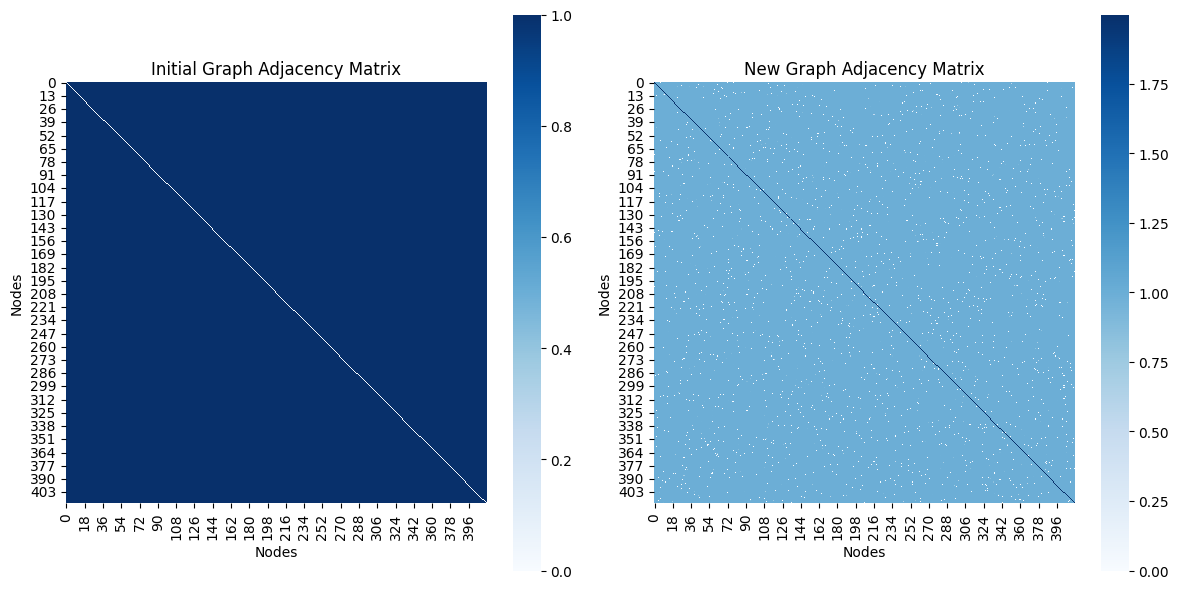

In [89]:
import matplotlib.pyplot as plt
import seaborn as sns
import torch

# Assuming initial_graph and new_graph are returned from to_dense_adj and are PyTorch tensors
# Move tensors to CPU and convert to numpy arrays
initial_graph_np = initial_graph.cpu().squeeze().numpy()  # Move to CPU, remove singleton dimensions, and convert to numpy
new_graph_np = new_graph.cpu().squeeze().numpy()  # Same for new_graph

# Set up the matplotlib figure
fig, ax = plt.subplots(1, 2, figsize=(12, 6))  # Create 2 subplots side by side

# Plot the initial graph adjacency matrix
sns.heatmap(initial_graph_np, cmap='Blues', ax=ax[0], square=True, cbar=True)
ax[0].set_title('Initial Graph Adjacency Matrix')
ax[0].set_xlabel('Nodes')
ax[0].set_ylabel('Nodes')

# Plot the new graph adjacency matrix
sns.heatmap(new_graph_np, cmap='Blues', ax=ax[1], square=True, cbar=True)
ax[1].set_title('New Graph Adjacency Matrix')
ax[1].set_xlabel('Nodes')
ax[1].set_ylabel('Nodes')

# Adjust layout
plt.tight_layout()
plt.show()


***
# ***

In [ ]:
#del model
gc.collect()
torch.cuda.empty_cache()
torch.cuda.reset_peak_memory_stats()
print(torch.cuda.memory_summary(device=None, abbreviated=False))

|===========================================================================|
|                  PyTorch CUDA memory summary, device ID 0                 |
|---------------------------------------------------------------------------|
|            CUDA OOMs: 1            |        cudaMalloc retries: 4         |
|===========================================================================|
|        Metric         | Cur Usage  | Peak Usage | Tot Alloc  | Tot Freed  |
|---------------------------------------------------------------------------|
| Allocated memory      |   31744 B  |   31744 B  |    6440 GB |    6440 GB |
|       from large pool |       0 B  |       0 B  |    5523 GB |    5523 GB |
|       from small pool |   31744 B  |   31744 B  |     916 GB |     916 GB |
|---------------------------------------------------------------------------|
| Active memory         |   31744 B  |   31744 B  |    6440 GB |    6440 GB |
|       from large pool |       0 B  |       0 B  |    5523 GB |